# Shapelets

In [89]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pyts.transformation import ShapeletTransform

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

%run ../sys_configs.ipynb

## Introduction

Shapelets are introduced in [1] as *snippets* of time series observations that can be used to classify an unlabelled time series, the distance between the unlabelled time series and the snippet being within a distance threshold.

If we let $X = (x_{1},...,x_{n})$ be a time series where $x_{i} \in \mathbb{R}^{6}$ and $S = (s_{1}, ..., s_{l})$ where $s_{j} \in \mathbb{R}^{6}$ define a shapelet of length $l$, then the distance between the time series and the shapelet is defined as:
$dist(S, X) = min_{j \in \{0, ..., n-l\}}\Sigma_{k=1}^{l}(s_{k} - x_{j+k})^{2}.$

Shapelet identification algorithms can fit into the special cases of either *shapelet discovery* or *shapelet learning* (via gradient descent). 

Begin by reading in the sampled data produced by window method 1. We read in a sampled version; the original suffered from a major class imbalance problem. 

In [2]:
with open('../data/1s_train.npy', 'rb') as f:
    x1s_train = np.load(f)
    y1s_train = np.load(f)
sz, dim = x1s_train.shape[1:]
    
with open('../data/1s_val.npy', 'rb') as f:
    x1s_val = np.load(f)
    y1s_val = np.load(f)

## Approach 1: Shapelet Transform

### Approach

The Shapelet Transform identifies all the shapelets with a length belonging to a pre-determined range and selects the best shapelets among these candidates. 

This is a multistep process. After extracting valid shapelets of varying lengths across the time series, the distance between each shapelet and time series is calculated using a metric like DTW or the Euclidean distance. The data is then transformed into a new feature space where each feature corresponds to the distance to a particular shapelet. We then compute the F-statistic for each shapelet to determine its discriminative power; the F-statistic compares the between group (class) variance with the within group variance and the most discriminative shapelets are those with the highest F-statistics. The shapelets are ranked based on their F-statistics and the shapelets with the highest F-statistics are chosen as the best shapelets for classification. Self-similar shapelets are then removed. Two shapelets are self similar if they are from the same time series and have a minimum of one overlapping index.

This all amounts to an exercise in feature selection. Once the shapelets are selected, it is possible to run all the usual classification techniques like nearest neighbours and support vector machines to complete the classification task.

The Shapelet Transform method is highly computationally expensive, on the order of $O(N^{2}n^{4})$ assuming there are N time series in the dataset. Shapelets do not easily extend to multi-dimensional time series and the Shapelet Transform has not been implemented in Pyts. We compute component-by-component Shapelet Transforms, identifying the most informative Shapelets in each and merging the result.

### Train data size vs compute times

Shapelets transforms are the most computationally expensive of the techniques we will study in this work. We first explore with a small experiment how the train size affects the compute time.

In [3]:
fit_times = []
samples = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]

for s in samples:
    start_time = time.time()
    st_example = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True, verbose = 0)
    st_example.fit(x1s_train[:s, :, 0], y1s_train[:s]) # Use the x-component of the acceleration; the component is not important.
    
    t = time.time() - start_time
    fit_times.append(t) 

Text(0, 0.5, 'Time to Run/second')

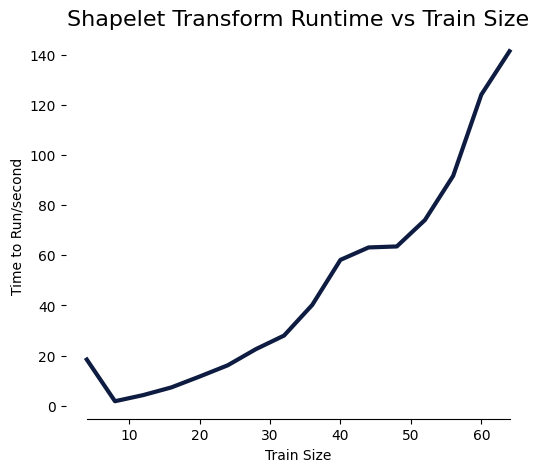

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))

# Define font sizes
SIZE_DEFAULT = 14
SIZE_LARGE = 16
plt.rc("font", weight="normal")  # controls default font
plt.rc("font", size=SIZE_DEFAULT)  # controls default text sizes
plt.rc("axes", titlesize=SIZE_LARGE)  # fontsize of the axes title
plt.rc("axes", labelsize=SIZE_LARGE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SIZE_DEFAULT)  # fontsize of the tick labels

ax.plot(samples, fit_times, color=scale_rgb(COLOURS.get("accent-blue-dark-1")), linewidth=3)
   
# Hide the all but the bottom spines (axis lines)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.spines["bottom"].set_bounds(min(samples), max(samples))

plt.title("Shapelet Transform Runtime vs Train Size")
ax.set_xlabel("Train Size")
ax.set_ylabel("Time to Run/second")

"The train data size is $\approx 3,600 = 60 x 60$. Therefore the projected runtime is $80*60^{2}$ = $288,000$ seconds $\approx 80$ hours. We therefore choose a secondary sample from our train dataset such that the cumulative train time across all components can be kept within 30 mins, i.e. 300 seconds per component. Given the compute time with 60 samples was around 80 seconds, we use 3 samples per group for a total of 90 samples.

### Train

In [4]:
N = len(x1s_train)
sz = 200

# Choose the secondary sample indexes
random_idxs = np.random.choice(N, size = sz, replace=False)

# Obtain each of the 6 components of the sensor data
train_acc_x = x1s_train[random_idxs, :, 0]
train_acc_y = x1s_train[random_idxs, :, 1]
train_acc_z = x1s_train[random_idxs, :, 2]
train_gyr_x = x1s_train[random_idxs, :, 3]
train_gyr_y = x1s_train[random_idxs, :, 4]
train_gyr_z = x1s_train[random_idxs, :, 5]

# Obtain the corresponding class labels from the indexes
y_train = y1s_train[random_idxs]

In [5]:
# Initialise, then fit, the Shapelet transform
st_acc_x = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True)
st_acc_y = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True)
st_acc_z = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True)
st_gyr_x = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True)
st_gyr_y = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True)
st_gyr_z = ShapeletTransform(n_shapelets = 10, window_sizes=[5], criterion = "anova", remove_similar = True)

In [17]:
acc_x_shapelets = st_acc_x.fit(train_acc_x, y_train)
acc_y_shapelets = st_acc_y.fit(train_acc_y, y_train)
acc_z_shapelets = st_acc_z.fit(train_acc_z, y_train)
gyr_x_shapelets = st_gyr_x.fit(train_gyr_x, y_train)
gyr_y_shapelets = st_gyr_y.fit(train_gyr_y, y_train)
gyr_z_shapelets = st_gyr_z.fit(train_gyr_z, y_train)

Now that the most discriminative Shapelets have been selected, we train a supervised machine learning model using the degree of similarity between each time series and each shapelet as the features.

In [18]:
# Extract the features as described above
train_acc_x_features = acc_x_shapelets.transform(train_acc_x)
train_acc_y_features = acc_y_shapelets.transform(train_acc_y)
train_acc_z_features = acc_z_shapelets.transform(train_acc_z)
train_gyr_x_features = gyr_x_shapelets.transform(train_gyr_x)
train_gyr_y_features = gyr_y_shapelets.transform(train_gyr_y)
train_gyr_z_features = gyr_z_shapelets.transform(train_gyr_z)

# Concatenate the features
train_features = np.hstack([train_acc_x_features, 
                            train_acc_y_features,
                            train_acc_z_features,
                            train_gyr_x_features,
                            train_gyr_y_features,
                            train_gyr_z_features
                           ])

In [19]:
knn = KNeighborsClassifier(n_neighbors=10, metric = "cosine")
knn.fit(train_features, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=10)

In [20]:
svc = svm.SVC(degree=3, C=0.5)
svc.fit(train_features, y_train)

SVC(C=0.5)

In [38]:
rfc = RandomForestClassifier(max_depth=2, n_estimators=100, min_samples_split=5, criterion = "gini")
rfc.fit(train_features, y_train)

RandomForestClassifier(max_depth=2, min_samples_split=5)

### Predict

In [22]:
# Obtain each of the 6 components of the sensor data
test_acc_x = x1s_val[:, :, 0]
test_acc_y = x1s_val[:, :, 1]
test_acc_z = x1s_val[:, :, 2]
test_gyr_x = x1s_val[:, :, 3]
test_gyr_y = x1s_val[:, :, 4]
test_gyr_z = x1s_val[:, :, 5]

In [23]:
test_acc_x_features = acc_x_shapelets.transform(test_acc_x)
test_acc_y_features = acc_y_shapelets.transform(test_acc_y)
test_acc_z_features = acc_z_shapelets.transform(test_acc_z)
test_gyr_x_features = gyr_x_shapelets.transform(test_gyr_x)
test_gyr_y_features = gyr_y_shapelets.transform(test_gyr_y)
test_gyr_z_features = gyr_z_shapelets.transform(test_gyr_z)

In [24]:
# Concatenate the features
test_features = np.hstack([test_acc_x_features, 
                           test_acc_y_features,
                           test_acc_z_features,
                           test_gyr_x_features,
                           test_gyr_y_features,
                           test_gyr_z_features
                          ])

In [25]:
knn.score(test_features, y1s_val)

0.04716981132075472

In [26]:
svc.score(test_features, y1s_val)

0.05849056603773585

In [39]:
rfc.score(test_features, y1s_val)

0.0660377358490566

The problem with this approach is that it cannot scale. Operations on a sample of just 100 mean we can expect just 2-3 samples of each class to train on. This would explain why the performance of the classifiers is so weak.

### Visualise

In [112]:
def get_most_discriminative_shapelets(model, data, labels, n, title):
    N = len(data)

    fig, axes = plt.subplots(figsize = (12, 5))

    # Iterate through the 3 most discriminative shapelets in this component
    for i, index in enumerate(model.indices_[:n]):
        idx, start, end = index
        label = ACTIVITY_MAPPING.get(labels[idx]) # Get the activity label
        
        # Plot the time series and the shapelet
        plt.plot(train_acc_x[idx, :], color='C{}'.format(i), label='Sample {} - {}'.format(idx, label), linewidth = 0.25, zorder= 1)
        plt.plot(np.arange(start, end), train_acc_x[idx, start:end], lw=5, color='C{}'.format(i), zorder = 2, alpha = 0.5)

    axes.set_xticks([])
    axes.set_xlabel('')

    axes.set_yticks([])
    axes.set_ylabel('')

    plt.title(title, fontsize=10, color = scale_rgb(COLOURS.get("primary-color")))
    plt.legend(loc='lower right', fontsize=8)
    plt.show()

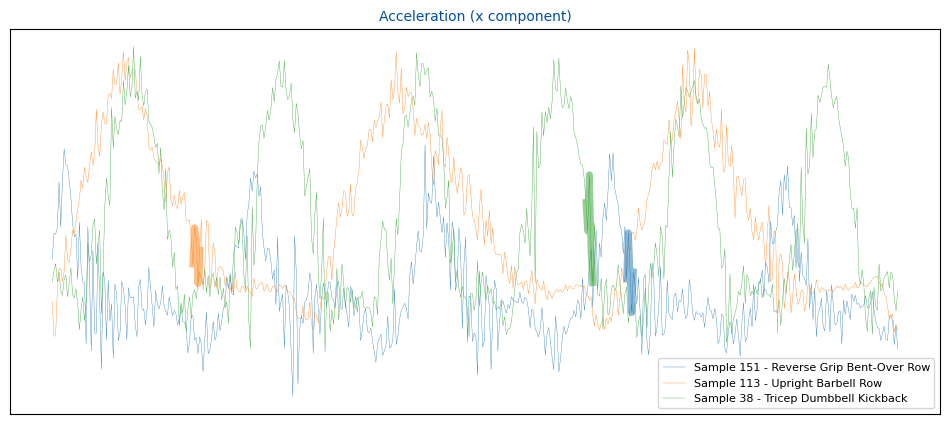

In [113]:
get_most_discriminative_shapelets(model = st_acc_x, data = train_acc_x, labels = y_train, n = 3, title = "Acceleration (x component)")

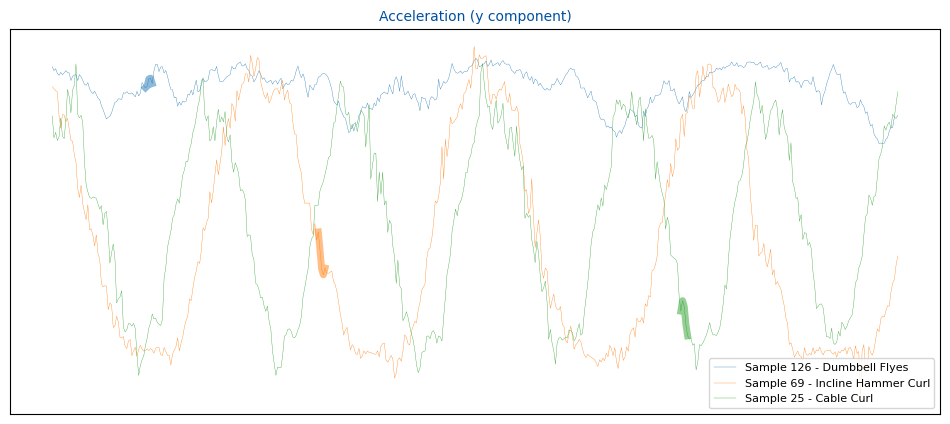

In [114]:
get_most_discriminative_shapelets(model = st_acc_y, data = train_acc_y, labels = y_train, n = 3, title = "Acceleration (y component)")

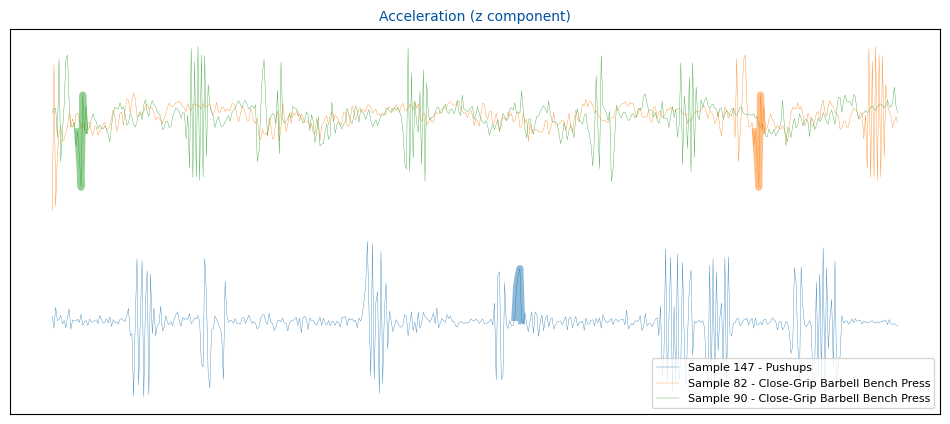

In [115]:
get_most_discriminative_shapelets(model = st_acc_z, data = train_acc_z, labels = y_train, n = 3, title = "Acceleration (z component)")

The visualisations allow us to see the most discriminative shapelets in each component. However, the results are only marginally better than randomly guessing the activity class. There is not much useful information contained within 5 observations from a single component.

## Appendix

### Approach 2: Learning Shapelets

The other class of Shapelet algorithms are those dedicated to learning shapelets via gradient descent rather than extracting them, then applying a logistic regressor. The key idea is to have differentiable transformation and classification function, and using the chain rule of differentiation to compute the gradients w.r.t. the shapelets. Learning shapelets is faster than extracting shapelets, and may lead to shapelets that are actually more discriminative than those that can be found in the dataset. 

### Train

In [141]:
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=len(x1s_train),
                                                       ts_sz=500,
                                                       n_classes=len(set(y1s_train)),
                                                       l=0.1,
                                                       r=1)

# Define the model using parameters provided by the authors (except that we
# use fewer iterations here)
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=20,
                            random_state=42,
                            verbose=10)

C:\Users\chris\AppData\Roaming\Python\Python39\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


### Predict

In [143]:
start_time = time.time()
shp_clf.fit(x1s_train, y1s_train)
t = time.time() - start_time
print("Finished training. Duration {}".format(t))

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Finished training. Duration 2644.88213968277


In [144]:
pred_labels = shp_clf.predict(x1s_val)
print("Correct classification rate:", accuracy_score(y1s_val, pred_labels))

Correct classification rate: 0.07547169811320754


## References

[1] Keogh, Eamonn J. and Thanawin Rakthanmanon. “Fast Shapelets: A Scalable Algorithm for Discovering Time Series Shapelets.” SDM (2013).

[2] Lines, Jason, Luke M. Davis, Jon Hills and A. Bagnall. “A shapelet transform for time series classification.” Knowledge Discovery and Data Mining (2012).

[3] Grabocka, Josif, Nicolas Schilling, Martin Wistuba and Lars Schmidt-Thieme. “Learning time-series shapelets.” Proceedings of the 20th ACM SIGKDD international conference on Knowledge discovery and data mining (2014): n. pag.